This project examines few months of data of a fictional startup.

Dilan is a world traveler and a solo entrepreneur. He writes a **travel blog** where he sells info products: a $8 e-book (World Travelers' Best Practices) and a $80 video course (How To Travel the World).

The project seeks the answers for these questions:
1. In which country should he prioritise his effort and why?
2. Any other advice to Dilan on how to be smart with his investments based on the data from the last 3 months?
3. Is there interesting information (beyond the above 2 questions) in the data from which Dilan could profit?

You can read more details in the readme file.

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


## Data preparation for analysis

In [2]:
complete_dataset = pd.read_csv('dilans_data.csv', delimiter=';', names = ['event_date', 'event', 'country',
                                                                          'user_id', 'source', 'topic'])
complete_dataset

,event_date,event,country,user_id,source,topic
0,2018-01-01 00:01:01,read,country_7,2.458151e+09,SEO,North America
1,2018-01-01 00:03:20,read,country_7,2.458151e+09,SEO,South America
2,2018-01-01 00:04:01,read,country_7,2.458151e+09,AdWords,Africa
3,2018-01-01 00:04:02,read,country_7,2.458151e+09,AdWords,Europe
4,2018-01-01 00:05:03,read,country_8,2.458151e+09,Reddit,North America
...,...,...,...,...,...,...
597897,2018-03-31 04:34:32,read,country_4,2.458361e+09,Africa,NaN
597898,2018-03-31 05:02:06,read,country_6,2.458361e+09,Asia,NaN
597899,2018-03-31 05:02:14,read,country_7,2.458361e+09,North America,NaN
597900,2018-03-31 05:03:53,read,country_7,2.458361e+09,Europe,NaN


In [3]:
# I split the first column into date and time so it's easier to work with.

new = complete_dataset["event_date"].str.split(" ", n = 1, expand = True)
complete_dataset["event_date"]= new[0]
complete_dataset["event_time"]= new[1]

complete_dataset = complete_dataset[['event_date','event_time','event','country','user_id','source','topic']]
complete_dataset['event_date'] = pd.to_datetime(complete_dataset['event_date'])


# After analysing the daily readers/subscribers/buyers metrics,
# I decided to remove the last day's data (2018-03-31) from the analysis as it is incomplete
# and only includes events between 00:00 and around 05:00 o'clock.

complete_dataset.drop(complete_dataset[complete_dataset['event_date'] == '2018-03-31'].index, inplace=True)

In [4]:
# creating a dataframe of subscribers

subscribers = complete_dataset.loc[complete_dataset.event=='subscribe']
subscribers = subscribers.drop(['user_id', 'source', 'topic'], axis=1)
subscribers.columns = ['event_date','event_time', 'event', 'user_id']
subscribers.user_id = subscribers.user_id.astype('float64')

In [5]:
# creating a dataframe of customers

buyers = complete_dataset.loc[complete_dataset.event=='buy']
buyers = buyers.drop(['source', 'topic'], axis=1)
buyers.columns = ['event_date','event_time', 'event', 'user_id', 'revenue']
buyers.user_id = buyers.user_id.astype('float64')

In [6]:
# creating a dataframe of readers

readers = complete_dataset.loc[complete_dataset.event=='read']

# the topic and source columns are messy because of the later reads not showing source

topics = ['Africa', 'Asia', 'Australia', 'Europe', 'North America', 'South America']

for i in topics:
    readers.source, readers.topic = np.where(readers.source == i, [readers.topic, readers.source], [readers.source, readers.topic])

/home/atidata/.local/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Exploratory data analysis

#### Daily Subscribers

In [7]:
# daily subscribers number over time

daily_subscribers = subscribers[['event_date', 'event']].groupby('event_date').count()


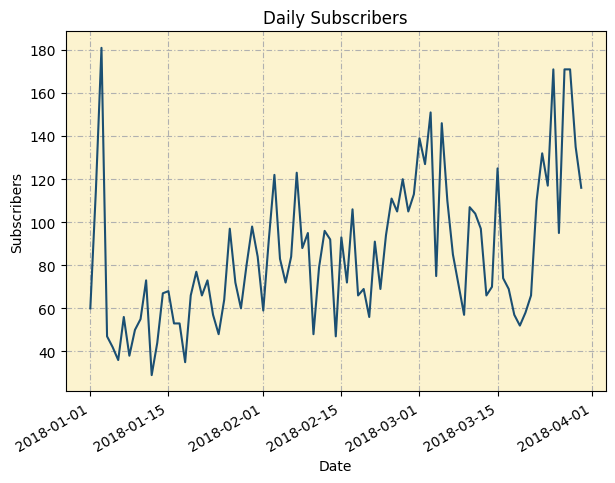

In [8]:
# visualizing daily subscribers

fig_1 = plt.figure(figsize=(6,4), dpi=100)
axes_1 = fig_1.add_axes([0.1,0.1,0.9,0.9])
axes_1.set_xlabel("Date")
axes_1.set_ylabel("Subscribers")
axes_1.set_title('Daily Subscribers')
axes_1.grid(True, dashes=(5,2,1,2))
axes_1.set_facecolor("#FCF3CF")

plt.plot(daily_subscribers, color="#1B4F72")
fig_1.autofmt_xdate()

In [9]:
daily_subscribers.describe()

,event
count,89.000000
mean,85.595506
std,33.671447
min,29.000000
25%,60.000000
50%,77.000000
75%,106.000000
max,181.000000


#### Daily readers

In [10]:
# number of daily readers

daily_readers = readers[['event_date', 'event']].groupby('event_date').count()


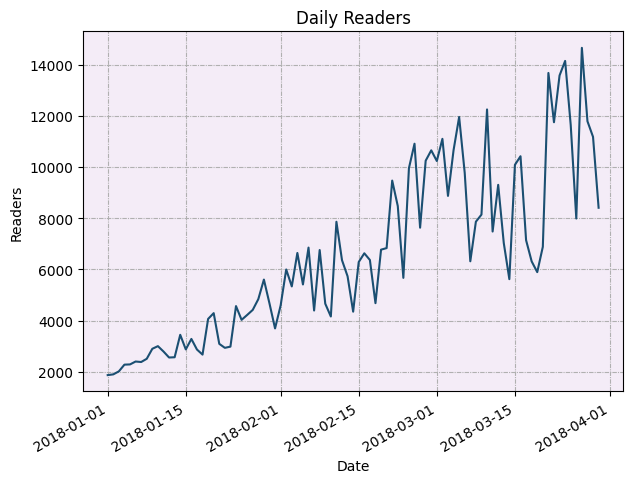

In [11]:
# Visualizing daily readers

fig_2 = plt.figure(figsize=(6,4), dpi=100)
axes_2 = fig_2.add_axes([0.1,0.1,0.9,0.9])
axes_2.set_xlabel("Date")
axes_2.set_ylabel("Readers")
axes_2.set_title('Daily Readers')
axes_2.grid(True, dashes=(4,1,1,1))
axes_2.set_facecolor("#F4ECF7")

plt.plot(daily_readers, color="#1B4F72")
fig_2.autofmt_xdate()

In [12]:
daily_readers.describe()

,event
count,89.000000
mean,6536.460674
std,3337.890699
min,1867.000000
25%,4027.000000
50%,6287.000000
75%,8872.000000
max,14659.000000


#### Daily customers

In [13]:
# number of daily customers

daily_buyers = buyers[['event_date', 'user_id']].groupby('event_date').nunique()


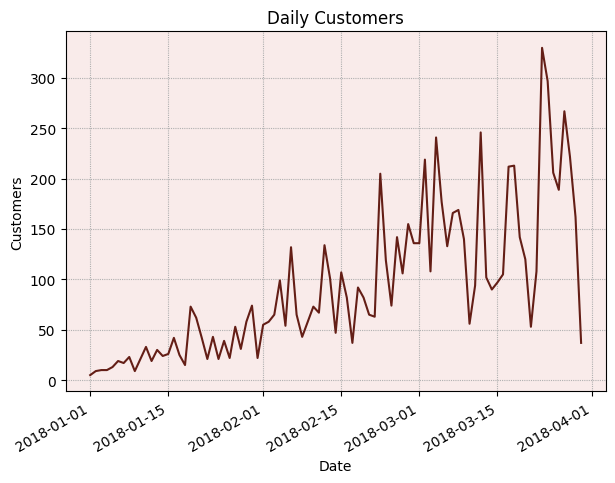

In [14]:
# Visualizing daily customers

fig_3 = plt.figure(figsize=(6,4), dpi=100)
axes_3 = fig_3.add_axes([0.1,0.1,0.9,0.9])
axes_3.set_xlabel("Date")
axes_3.set_ylabel("Customers")
axes_3.set_title('Daily Customers')
axes_3.grid(True, dashes=(1,1,1,1))
axes_3.set_facecolor("#F9EBEA")

plt.plot(daily_buyers, color="#641E16")
fig_3.autofmt_xdate()

In [15]:
# How many of the customers are subscribers as well?

sub_cust = subscribers.merge(buyers, on='user_id', how='inner')
sub_cust.user_id.nunique()

5076

#### Key metrics

In [16]:
# Daily revenue calculation

daily_rev = buyers[['event_date', 'revenue']].groupby('event_date').sum()

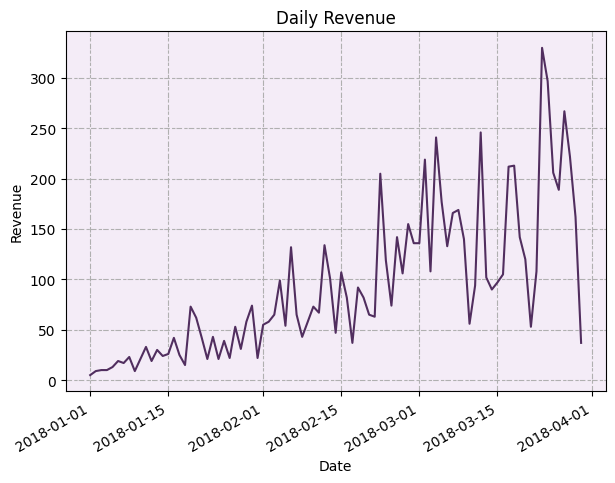

In [17]:
# Visualizing daily revenue

fig_4 = plt.figure(figsize=(6,4), dpi=100)
axes_4 = fig_4.add_axes([0.1,0.1,0.9,0.9])
axes_4.set_xlabel("Date")
axes_4.set_ylabel("Revenue")
axes_4.set_title('Daily Revenue')
axes_4.grid(True, dashes=(5,2,3,1))
axes_4.set_facecolor("#F4ECF7")

plt.plot(daily_rev, color="#512E5F")
fig_4.autofmt_xdate()

In [18]:
daily_rev.describe()

,revenue
count,89.000000
mean,2185.168539
std,1626.895560
min,200.000000
25%,784.000000
50%,1952.000000
75%,2896.000000
max,7424.000000


#### Daily Revenue By Product

In [19]:
# Splitting daily revenue between products

daily_book_rev = buyers.loc[buyers['revenue'] == 8].drop(['event_time', 'event', 'user_id'], axis=1).groupby('event_date').sum().reset_index()

In [20]:
daily_course_rev = buyers.loc[buyers['revenue'] == 80].drop(['event_time', 'event', 'user_id'], axis=1).groupby('event_date').sum().reset_index()

In [21]:
# creating a dataframe that shows how the revenue is generated

daily_rev_summary = daily_rev.merge(daily_book_rev, how='outer', on = 'event_date')

daily_rev_summary = daily_rev_summary.merge(daily_course_rev, how='outer', on='event_date')

daily_rev_summary = daily_rev_summary.set_index(["event_date"])

daily_rev_summary.columns = ['revenue', 'book_rev', 'course_rev']

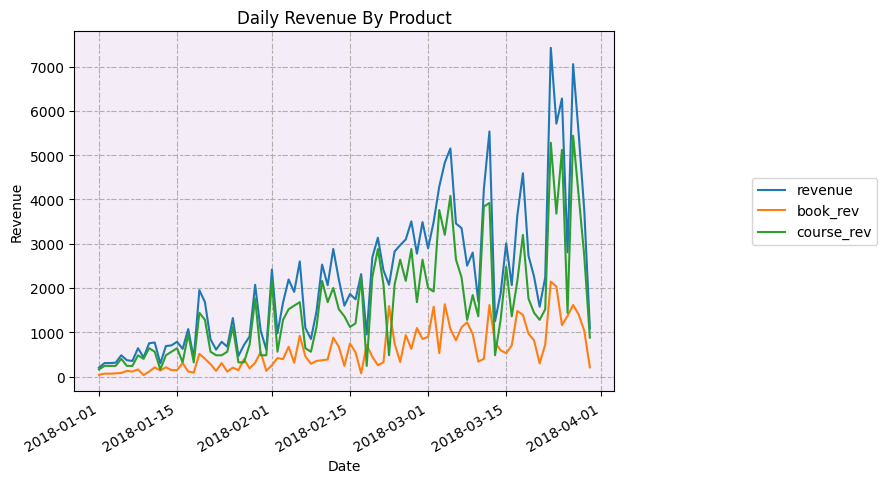

In [22]:
# Visualizing daily revenue

fig_5 = plt.figure(figsize=(6,4), dpi=100)
axes_5 = fig_5.add_axes([0.1,0.1,0.9,0.9])
axes_5.set_xlabel("Date")
axes_5.set_ylabel("Revenue")
axes_5.set_title('Daily Revenue By Product')
axes_5.grid(True, dashes=(5,2,3,1))
axes_5.set_facecolor("#F4ECF7")

plt.plot(daily_rev_summary)
fig_5.autofmt_xdate()
plt.legend(daily_rev_summary, loc="right", bbox_to_anchor=(1,0,0.5,1))

#### Daily acitivity

In [23]:
# Daily activity calculation

In [24]:
daily_active_users = complete_dataset[['event_date', 'user_id',]].groupby('event_date').nunique('user_id')

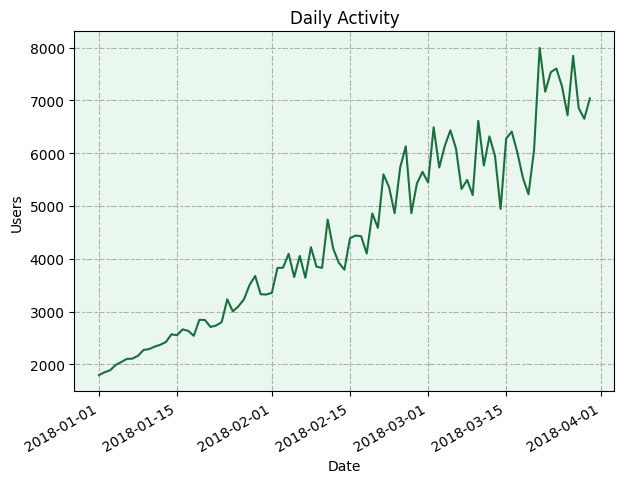

In [25]:
# Visualizing daily activity

fig_6 = plt.figure(figsize=(6,4), dpi=100)
axes_6 = fig_6.add_axes([0.1,0.1,0.9,0.9])
axes_6.set_xlabel("Date")
axes_6.set_ylabel("Users")
axes_6.set_title('Daily Activity')
axes_6.grid(True, dashes=(5,2,3,1))
axes_6.set_facecolor("#E9F7EF")

plt.plot(daily_active_users, color="#196F3D")
fig_6.autofmt_xdate()

#### Funnel

In [26]:
# Creating the parts of the funnel analysis

In [27]:
first_readers = readers[readers.source.notnull()].user_id.count()

In [28]:
returning_readers = readers[readers.source.isnull()].user_id.nunique()

In [29]:
sub_funnel = len(subscribers.index)

In [30]:
book_funnel = buyers.loc[buyers['revenue']== 8].user_id.count()

In [31]:
course_funnel = buyers.loc[buyers['revenue']== 80].user_id.count()

In [32]:
funnel = pd.DataFrame({'first_readers' : [first_readers], 'returning_readers' : [returning_readers], 'subscribers' : [sub_funnel],
                      'bought_book' : [book_funnel], 'bought_course' : [course_funnel]})

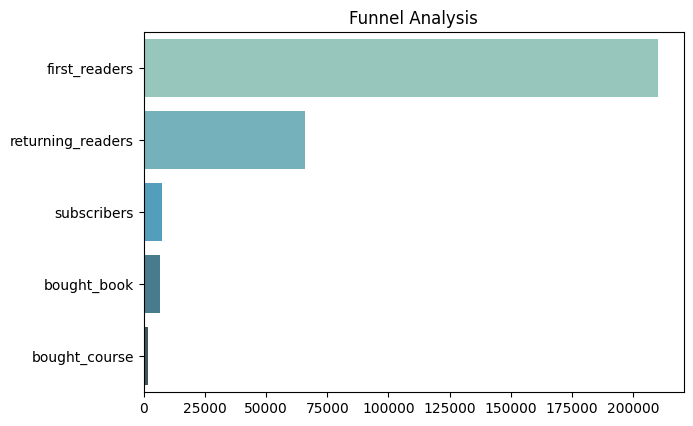

In [33]:
# Visualizing funnel

fig_7 = plt.figure(figsize=(6,4), dpi=100)
axes_7 = fig_7.add_axes([0.1,0.1,0.9,0.9])
axes_7.set_title("Funnel Analysis")
sns.barplot(data = funnel, orient = 'h', palette='GnBu_d')

## Feature analysis

#### Country analysis

In [34]:

# Which country has most of our customers?

customers_by_country = readers.merge(buyers, on='user_id', how='outer')

customers_by_country = customers_by_country.loc[customers_by_country.event_y == 'buy'].groupby('country').user_id.nunique().sort_values(ascending=False)

customers_by_country = customers_by_country.to_frame()

customers_by_country = customers_by_country.T

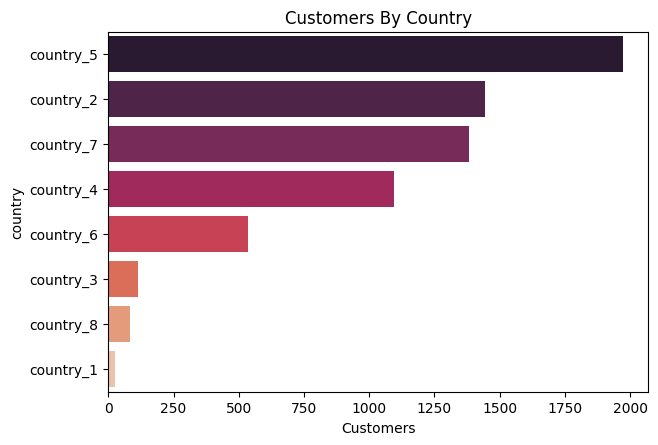

In [35]:
# Visualizing customers by country

fig_8 = plt.figure(figsize=(6,4), dpi=100)
axes_8 = fig_8.add_axes([0.1,0.1,0.9,0.9])
axes_8.set_title("Customers By Country")
plt.xlabel("Customers")
plt.ylabel("Country")
sns.barplot(data=customers_by_country, orient='h', palette='rocket')

In [36]:
# Which countries bring the most revenue?

country = readers[['user_id', 'country']].drop_duplicates(subset='user_id')
rev_by_country = buyers.merge(country, on='user_id', how='inner')
rev_by_country = rev_by_country.groupby('country').revenue.sum().sort_values(ascending=False).reset_index()


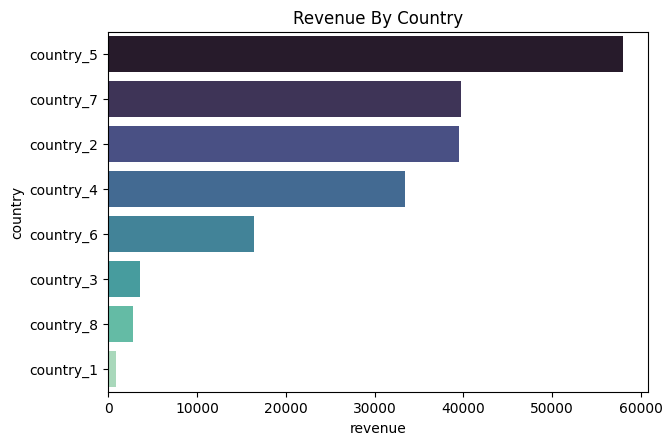

In [37]:
# Visualizing countries by revenue

fig_9 = plt.figure(figsize=(6,4), dpi=100)
axes_9 = fig_9.add_axes([0.1,0.1,0.9,0.9])
axes_9.set_title("Revenue By Country")

sns.barplot(y="country", x="revenue",data=rev_by_country, orient='h', palette='mako')

#### Topic Analysis

In [38]:
# Merging buyers df with readers

customers_by_topic = readers.merge(buyers, on='user_id', how='inner')

In [39]:
# On average how many of the 6 topics do customers read?

topic_mean = customers_by_topic.groupby('user_id').topic.nunique()

In [40]:
topic_mean.describe()

count    6648.000000
mean        5.107702
std         0.826346
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         6.000000
Name: topic, dtype: float64

In [41]:
# Which topic interests the most customers?

customers_by_topic = customers_by_topic.loc[customers_by_topic.event_y == 'buy'].groupby('topic').user_id.nunique().sort_values(ascending=False)

customers_by_topic= customers_by_topic.to_frame().reset_index()

customers_by_topic.columns=['Topic', 'Customers']

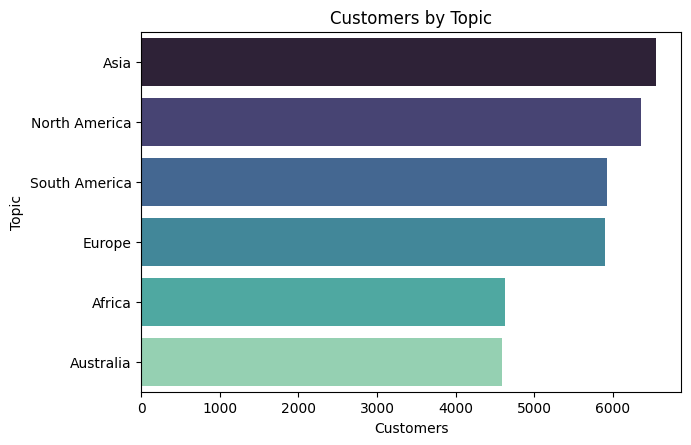

In [42]:
# Visualizing customers by topic

fig_10 = plt.figure(figsize=(6,4), dpi=100)
axes_10 = fig_10.add_axes([0.1,0.1,0.9,0.9])
axes_10.set_title("Customers by Topic")

sns.barplot(y="Topic", x="Customers",data=customers_by_topic, orient='h', palette='mako', ax=axes_10)

In [43]:
# Which topic interests the most readers? 

readers_by_topic = readers.groupby('topic').user_id.count().sort_values(ascending=False).reset_index()
readers_by_topic.columns = ['Topic', "Readers"]

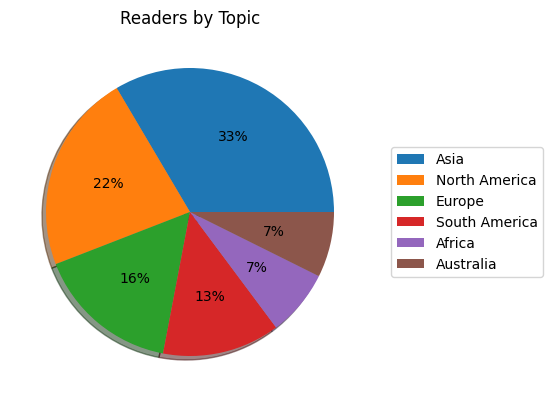

In [44]:
# Visualizing readers by topic

fig_11 = plt.figure(figsize=(6,4), dpi=100)
axes_11 = fig_11.add_axes([0.1,0.1,0.9,0.9])
axes_11.set_title("Readers by Topic")

plt.pie(readers_by_topic['Readers'], shadow = True, autopct="%1.0f%%")
plt.legend(readers_by_topic["Topic"], loc="right", bbox_to_anchor=(1,0,0.5,1))

In [45]:
# Which topic interests the most returning readers? 

returning_readers_by_topic = readers[readers.source.isnull()].groupby('topic').user_id.count().sort_values(ascending=False).reset_index()
returning_readers_by_topic.columns = ["Topic", "Returning Readers"]

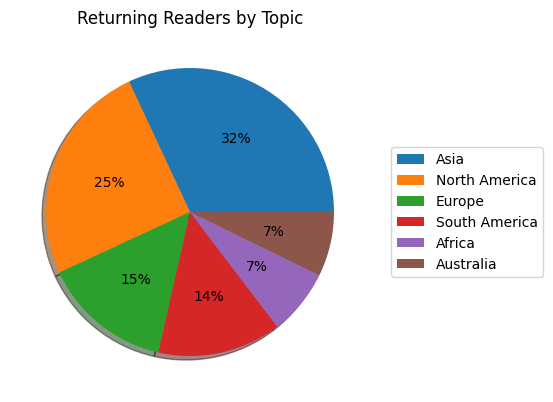

In [46]:
fig_12 = plt.figure(figsize=(6,4), dpi=100)
axes_12 = fig_12.add_axes([0.1,0.1,0.9,0.9])
axes_12.set_title("Returning Readers by Topic")

plt.pie(returning_readers_by_topic['Returning Readers'], shadow = True, autopct="%1.0f%%")
plt.legend(returning_readers_by_topic["Topic"], loc="right", bbox_to_anchor=(1,0,0.5,1))

#### Source Analysis

In [47]:
# Which source brings the most readers?

readers_by_source = readers[['source', 'user_id']].groupby('source').user_id.nunique().sort_values(ascending=False)

readers_by_source = readers_by_source.to_frame().reset_index()
readers_by_source.columns = ["Source", "Readers"]

In [48]:
# Which source brings the most customers?

customers_by_source = readers.merge(buyers, on='user_id', how='inner')
customers_by_source = customers_by_source.loc[customers_by_source.event_y == 'buy'].groupby('source').user_id.nunique().sort_values(ascending=False)
customers_by_source = customers_by_source.to_frame().reset_index()
customers_by_source.columns = ["Source", "Customers"]

In [49]:
# Which source brings the most revenue?

rev_by_source = buyers.merge(readers, on='user_id', how='inner')
rev_by_source = rev_by_source.groupby('source').revenue.sum().sort_values(ascending=False)
rev_by_source = rev_by_source.to_frame().reset_index()
rev_by_source.columns = ["Source", "Revenue"]

In [50]:
# Which source brings the most subscribers?

sub_by_source = subscribers.merge(readers, on='user_id', how='inner')
sub_by_source = sub_by_source.groupby('source').user_id.nunique().sort_values(ascending=False)
sub_by_source = sub_by_source.to_frame().reset_index()
sub_by_source.columns = ["Source", "Subscribers"]

Text(0.5, 1.0, 'Subscribers By Source')

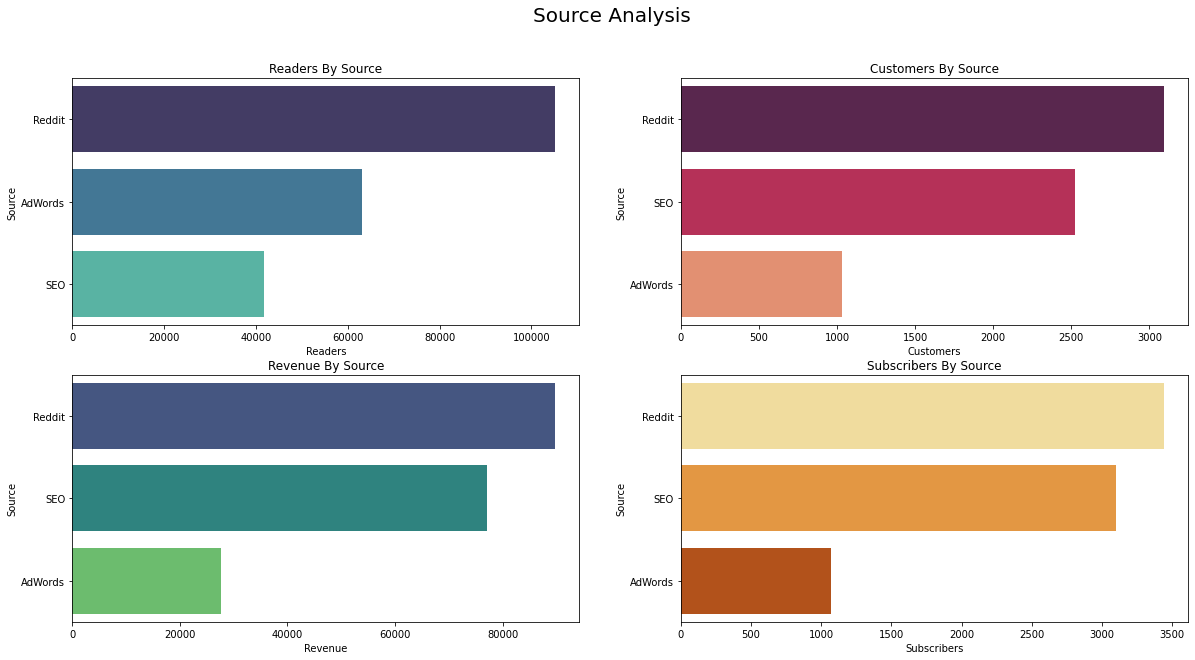

In [51]:
# Visualizing source metrics

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
fig.suptitle("Source Analysis", fontsize=20)

sns.barplot(y="Source", x="Readers",data=readers_by_source, orient='h', palette='mako', ax=axes[0,0])
axes[0,0].set_title("Readers By Source")

sns.barplot(y="Source", x="Customers",data=customers_by_source, orient='h', palette='rocket', ax=axes[0,1])
axes[0,1].set_title("Customers By Source")

sns.barplot(y="Source", x="Revenue",data=rev_by_source, orient='h', palette='viridis', ax=axes[1,0])
axes[1,0].set_title("Revenue By Source")

sns.barplot(y="Source", x="Subscribers",data=sub_by_source, orient='h', palette="YlOrBr", ax=axes[1,1])
axes[1,1].set_title("Subscribers By Source")


## Segmentation

In [52]:
# What are the most profitable segments?

source = readers[['user_id', 'source']].drop_duplicates(subset='user_id')
segments = buyers.merge(country, on='user_id')
segments = segments.merge(source, on='user_id')
segments = segments.groupby(['country', 'source']).revenue.sum().sort_values(ascending=False)

In [53]:
display(segments)

country    source 
country_5  Reddit     28056.0
           SEO        20184.0
country_2  Reddit     18688.0
country_7  Reddit     18600.0
country_2  SEO        17552.0
country_7  SEO        16752.0
country_4  Reddit     15032.0
country_5  AdWords     9680.0
country_4  AdWords     9336.0
           SEO         9096.0
country_6  SEO         8200.0
           Reddit      7536.0
country_7  AdWords     4408.0
country_2  AdWords     3288.0
country_8  SEO         2832.0
country_3  Reddit      1848.0
           SEO         1520.0
country_1  SEO          920.0
country_6  AdWords      696.0
country_3  AdWords      248.0
country_8  AdWords        8.0
Name: revenue, dtype: float64

## Machine Learning

In [54]:
# Using a random forest model to classify readers as customers.

#### Prepare data for modeling

In [55]:
# I need customer(0 or 1) as the y variable stating if the reader has bought one of the products
# The features are: 
#              country (the readers nationality), 
#              source (which marketing channel brought them here), 
#              subscribed (has she subscribed?)
#              num_topic (how many of the 6 topics has he read?)
#              num_reads (how many times has she read on the blog?)

In [56]:
users = readers[readers.source.notnull()][['user_id', 'country', 'source']].reset_index(drop=True)

In [57]:
users = users.merge(subscribers, on='user_id', how='outer')

In [58]:
users['event'] = users['event'].fillna(0)
users['event'] = users['event'].replace(to_replace='subscribe', value = 1)

In [59]:
num_topic = readers.groupby('user_id').topic.nunique().reset_index()

In [60]:
num_reads = readers.groupby('user_id').count()[['event']].reset_index()

In [61]:
users = users.merge(num_topic, on='user_id')
users = users.merge(num_reads, on='user_id')

In [62]:
users = users.merge(buyers[['user_id', 'event']], on= 'user_id', how = 'outer')

In [63]:
users['event'] = users['event'].fillna(0)
users['event'] = users['event'].replace(to_replace='buy', value = 1)

In [64]:
users = users.drop(['event_date', 'event_time'], axis=1)

In [65]:
users.columns = ['user_id', 'country', 'source', 'subscribed', 'num_topic', 'num_reads', 'customer']

In [66]:
source_dictionary = {'Reddit': 0, 'AdWords': 1, 'SEO': 2}
country_dictionary = {'country_1': 0, 'country_2': 1,'country_3': 2, 'country_4': 3, 'country_5': 4, 'country_6': 5,
                     'country_7': 6, 'country_8': 7}

In [67]:
users['source'] = users['source'].map(source_dictionary)
users['country'] = users['country'].map(country_dictionary)

In [68]:
users

,user_id,country,source,subscribed,num_topic,num_reads,customer
0,2.458151e+09,6,2,0,1,1,0
1,2.458151e+09,6,2,0,1,1,0
2,2.458151e+09,6,1,0,1,1,0
3,2.458151e+09,6,1,0,1,1,0
4,2.458151e+09,7,0,0,1,1,0
...,...,...,...,...,...,...,...
211777,2.458361e+09,0,2,0,1,1,0
211778,2.458361e+09,5,1,0,1,1,0
211779,2.458361e+09,7,1,0,1,1,0
211780,2.458361e+09,4,1,0,1,1,0


#### Modelling

In [69]:
# setting variables for the model

y = users['customer']
X = users[['country', 'source', 'subscribed', 'num_topic', 'num_reads']]




In [70]:
y.value_counts()

0    203375
1      8407
Name: customer, dtype: int64

In [71]:
# random state=1 so next time i run the model, it will give me the same result
# stratify=y so customers will be represented in the same proportion as in the original dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [72]:
# trainig model

forest = RandomForestClassifier(n_estimators = 100)
forest.fit(X_train, y_train)

RandomForestClassifier()

In [73]:
# predicting test set

y_pred_test = forest.predict(X_test)

#### Validation

In [74]:
# checking accuracy

accuracy_score(y_test, y_pred_test)

0.987666679258112

In [75]:
confusion_matrix(y_test, y_pred_test)

array([[50585,   259],
       [  394,  1708]])

In [76]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     50844
           1       0.87      0.81      0.84      2102

    accuracy                           0.99     52946
   macro avg       0.93      0.90      0.92     52946
weighted avg       0.99      0.99      0.99     52946



In [77]:
# number of reads seems to be the most helpful feature of the model

importance = forest.feature_importances_
print(importance)

[0.02111285 0.00766047 0.24545402 0.15610533 0.56966733]


## Exporting for tableau visualizations

In [79]:
# exporting for tableu visualizations

#daily_active_users.to_excel(r'daily_active_users.xlsx')
#daily_rev_summary.to_excel(r'daily_rev_summary.xlsx', index=False,)
#funnel.to_excel(r'funnel.xlsx', index=False)
#customers_by_country.to_excel(r'customers_by_country.xlsx')
#customers_by_topic.to_excel(r'customers_by_topic.xlsx')
#readers_by_topic.to_excel(r'readers_by_topic.xlsx')
#rev_by_country.to_excel(r'rev_by_country.xlsx')
#segments.to_excel(r'segments.xlsx')